In [1]:
%config Completer.use_jedi = False

2022 PHME Data Challenge, encourage participants to solve multiple classification problems for a real production line from Bitron Spa. The dataset includes data from SPI and AOI equipment of a real industrial production line equipped with automated, integrated and fully connected machines (Industry 4.0).
The goal is to design an algorithm to predict the defect labels for the components. Specifically, the goal is to develop a hierarchical classification predicting: 

1. whether the AOI classifies the component as defective; 
2. in the case of a defect, the label applied by the operator; 
3. in the case of confirmation of the defect by the operator, the repair label.

For more information about the data challenge and to enroll in it, please visit the https://phm-europe.org/data-challenge web page.



# Data exploration

The first thing to do, after loading the libraries, is to load and explore each data set (AOI and SPI).

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
plt.rcParams["figure.figsize"] = (14,10)


## AOI Data

the AOI data describe, for PCB each defect highlighted by the machine, the following characteristics:

*Identifiers:*
* PanelID
* FigureID
* MachineID
* ComponentID
* PinNumber

*Defect labels:*

* label according to the AOI machine
* label applied by the operator after visual inspection
* label applied by a second operator based on the possibility of repair.

In [3]:
InputAOI=pd.read_csv('data/AOI_training.csv.zip')

By exploring the head of the sorted dataframe we can see that for one PanelId, several set of identifiers can be found that result in different labels.

In [4]:
InputAOI.sort_values('PanelID').head(40)

,PanelID,FigureID,MachineID,ComponentID,PinNumber,AOILabel,OperatorLabel,RepairLabel
19504,25319088000520102844,6,A,U3,29.0,Jumper,Bad,FalseScrap
19506,25319088000520102844,7,B,BC2,2.0,UnSoldered,Good,NaN
19505,25319088000520102844,6,B,BC1,2.0,LeanSoldering,Good,NaN
19503,25319088000520102844,5,A,R2,1.0,Soldered,Good,NaN
19502,25319088000520102844,3,A,C8,NaN,Coplanarity,Good,NaN
19501,25319088000520102844,3,A,TRB3,2.0,Jumper,Bad,FalseScrap
19500,25319088000520102844,3,A,R2,NaN,Size,Good,NaN
48,26319044800520102844,2,A,R26,2.0,Soldered,Good,NaN
49,26319044800520102844,2,A,R26,NaN,Size,Good,NaN
50,26319044800520102844,3,A,D1,1.0,Soldered,Good,NaN


In [5]:
sum(InputAOI["OperatorLabel"]=="Bad")

1356

The singular information unit seems to be the set (PanelID, FigureID, MachineID, ComponentID, PinNumber) -> under this tuple all OperatorLabel and RepairLAbel seem to be the same even if the AOIlabel might be different (multiple defects found by the equipment)

In [6]:
aoi_grouped =InputAOI.groupby(['PanelID', 'FigureID', 'MachineID', 'ComponentID', 'PinNumber'])

In [7]:
size = aoi_grouped.size()
print("maximum number of labels :{}".format(size.max()))
size[size>2]

maximum number of labels :3


PanelID               FigureID  MachineID  ComponentID  PinNumber
26319055700520102844  1         A          U3           2.0          3
                                                        3.0          3
                                                        12.0         3
                                                        16.0         3
26319059400520102844  1         A          C12          1.0          3
                                                                    ..
27219002600520102844  7         A          C25          2.0          3
                      8         A          C25          2.0          3
27219003500520102844  1         A          C30          1.0          3
27219004100520102844  5         A          C30          1.0          3
27219031000520102844  6         A          U3           36.0         3
Length: 61, dtype: int64

Let's explore one of these cases

In [8]:
InputAOI.loc[(InputAOI['PanelID']=="26319055700520102844") & (InputAOI["FigureID"]==1) & (InputAOI["MachineID"]=="A") & (InputAOI["ComponentID"]=="U3")].sort_values(['PinNumber'])

,PanelID,FigureID,MachineID,ComponentID,PinNumber,AOILabel,OperatorLabel,RepairLabel
4174,26319055700520102844,1,A,U3,1.0,Translated,Bad,NotPossibleToRepair
4212,26319055700520102844,1,A,U3,1.0,Soldered,Bad,NotPossibleToRepair
4230,26319055700520102844,1,A,U3,2.0,Coplanarity,Bad,NotPossibleToRepair
4211,26319055700520102844,1,A,U3,2.0,Soldered,Bad,NotPossibleToRepair
4173,26319055700520102844,1,A,U3,2.0,Translated,Bad,NotPossibleToRepair
...,...,...,...,...,...,...,...,...
4176,26319055700520102844,1,A,U3,47.0,Translated,Bad,NotPossibleToRepair
4217,26319055700520102844,1,A,U3,48.0,Soldered,Bad,NotPossibleToRepair
4175,26319055700520102844,1,A,U3,48.0,Translated,Bad,NotPossibleToRepair
4075,26319055700520102844,1,A,U3,NaN,Coplanarity,Bad,NotPossibleToRepair


We can see that AOI defect labels aren't unique at pin level, neither they are at component level. Somethimes there is NaN on the PinNumber, but this doesn't seem ralated to the unavailability of the PinNumber or the presence of multiple errors.


let's verify that the *OperatorLabel* and the *RepairLabel* are always the same for a single component

In [9]:
InputAOI.loc[:, InputAOI.columns != 'AOILabel'].drop_duplicates().groupby(['PanelID', 'FigureID', 'MachineID', 'ComponentID', 'PinNumber', 'OperatorLabel', 'RepairLabel']).size().max()

1

We see two values for the `MachineID` field. Are all the Panel inspected by the two Machines? 

In [10]:
InputAOI.loc[:, ['PanelID', 'MachineID']].drop_duplicates().groupby(['MachineID']).size()

MachineID
A    1924
B    1884
dtype: int64

40 Panels seems to be only inpected by the machine A. all the others are inspected by the two machines.

Knowing this . lets' explore if the components are inspected by both machines or only one?

In [11]:
multi_test = InputAOI.loc[:, [x for x in InputAOI.columns if x not in ['AOILabel','OperatorLabel', 'RepairLabel']]].drop_duplicates().groupby(['PanelID', 'FigureID', 'ComponentID', 'PinNumber']).size()
multi_test[multi_test>1]

PanelID               FigureID  ComponentID  PinNumber
26319094000520102844  4         L1           1.0          2
26319096600520102844  5         L1           1.0          2
26919008900520102844  1         L1           1.0          2
26919009800520102844  1         L1           1.0          2
26919046900520102844  1         L1           1.0          2
27119033800520102844  7         L1           1.0          2
dtype: int64

It seems that `ComponentID L1` is the only component inspected by the Machine A and B and this double inspection is performed only for one panel.


Let's explore the distribution of the AOILabel values


<AxesSubplot:xlabel='AOILabel'>

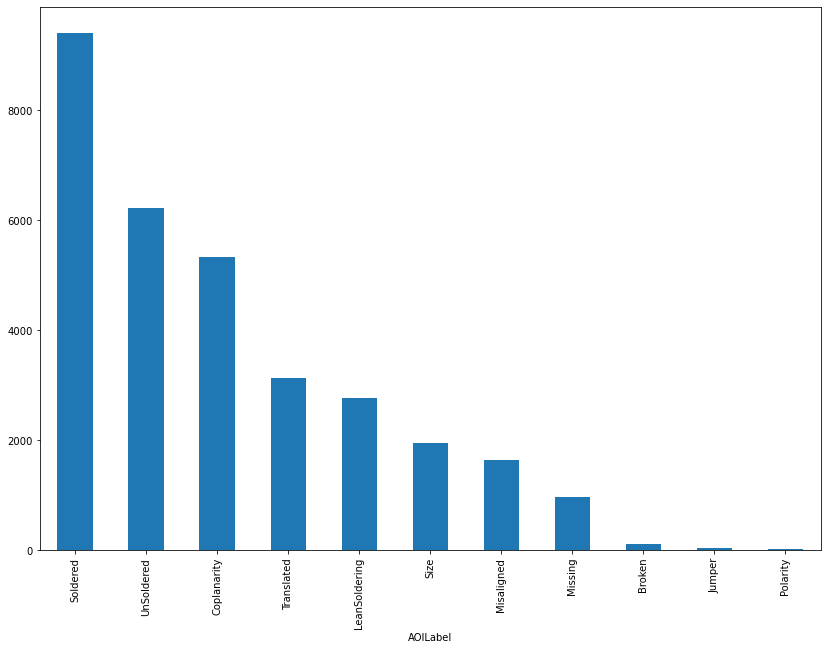

In [85]:
InputAOI.groupby('AOILabel').size().sort_values(ascending=False).plot(kind='bar')

Let's now explore the `OperatorLabel`, `RepairLabel` and their join distribution

In [93]:
InputAOI.groupby('OperatorLabel')['PanelID'].nunique()

OperatorLabel
Bad      177
Good    1919
Name: PanelID, dtype: int64

In [94]:

dict_OperatorLabel_AOILabel={}

dict_OperatorLabel_RepairLabel={}


for element in InputAOI.AOILabel.unique().tolist():
    InputAOI_int=InputAOI[InputAOI['AOILabel']==element]
    dict_OperatorLabel_AOILabel[element]=InputAOI_int.groupby("OperatorLabel").size()
    dict_OperatorLabel_RepairLabel[element]=InputAOI_int.groupby("RepairLabel").size()



<AxesSubplot:>

<Figure size 1332x756 with 0 Axes>

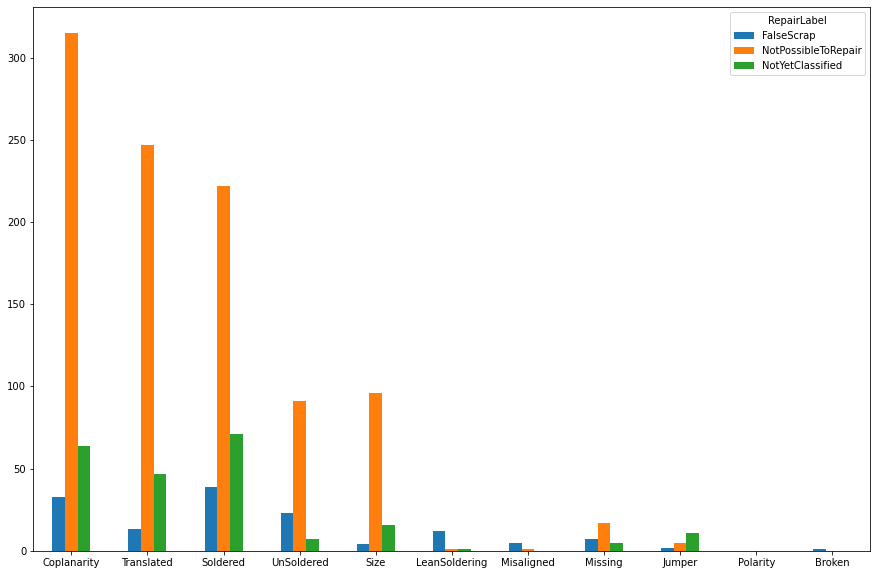

In [95]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
df=pd.DataFrame(dict_OperatorLabel_RepairLabel).T

df.plot.bar(rot=0,figsize=(15,10))



In [96]:
df

RepairLabel,FalseScrap,NotPossibleToRepair,NotYetClassified
Coplanarity,33.0,315.0,64.0
Translated,13.0,247.0,47.0
Soldered,39.0,222.0,71.0
UnSoldered,23.0,91.0,7.0
Size,4.0,96.0,16.0
LeanSoldering,12.0,1.0,1.0
Misaligned,5.0,1.0,NaN
Missing,7.0,17.0,5.0
Jumper,2.0,5.0,11.0
Polarity,NaN,NaN,NaN


RepairLabel,FalseScrap,NotPossibleToRepair,NotYetClassified,FalseScrap %,NotPossibleToRepair %,NotYetClassified %
Coplanarity,33.0,315.0,64.0,0.080097,0.764563,0.155340
Translated,13.0,247.0,47.0,0.042345,0.804560,0.153094
Soldered,39.0,222.0,71.0,0.117470,0.668675,0.213855
UnSoldered,23.0,91.0,7.0,0.190083,0.752066,0.057851
Size,4.0,96.0,16.0,0.034483,0.827586,0.137931
LeanSoldering,12.0,1.0,1.0,0.857143,0.071429,0.071429
Misaligned,5.0,1.0,NaN,0.833333,0.166667,NaN
Missing,7.0,17.0,5.0,0.241379,0.586207,0.172414
Jumper,2.0,5.0,11.0,0.111111,0.277778,0.611111
Polarity,NaN,NaN,NaN,NaN,NaN,NaN


<Figure size 1332x756 with 0 Axes>

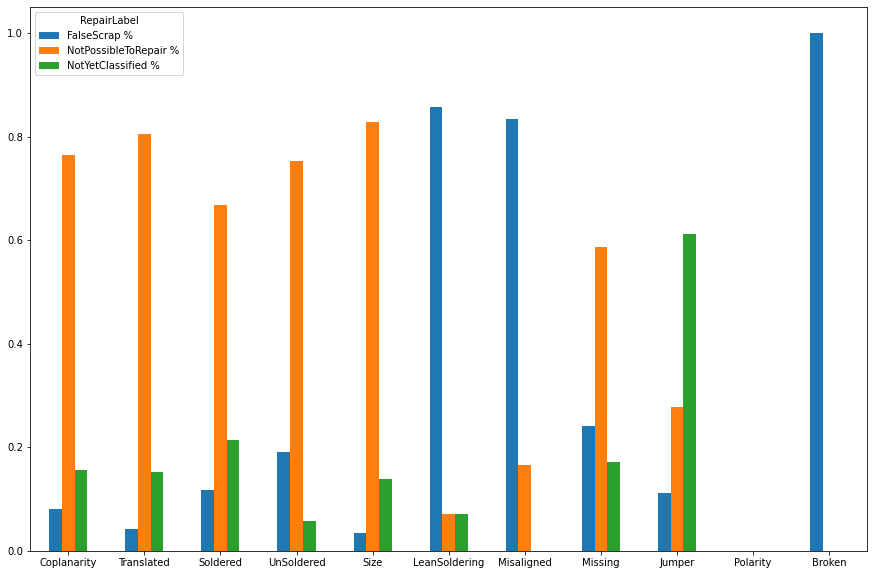

In [97]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
df=pd.DataFrame(dict_OperatorLabel_RepairLabel).T

divisor=df.sum(axis=1)

df['FalseScrap %']=df['FalseScrap'].div(divisor)

df['NotPossibleToRepair %']=df['NotPossibleToRepair'].div(divisor)

df['NotYetClassified %']=df['NotYetClassified'].div(divisor)


df[['FalseScrap %','NotPossibleToRepair %','NotYetClassified %']].plot.bar(rot=0,figsize=(15,10))
df


## SPI Data

the SPI data, reports, for each PCB, the following characteristics

*Event information:*
* Date
* Time

*Identifiers:*
* PanelID
* FigureID
* ComponentID
* PinNumber
* PadID
* PadType

*Soldering paste characteristics:*

* Volume both on µm3 and (%)
* Area both on µm2 and (%)
* Height on µm
* Positional Offset on X and Y (%)
* Pad size on X and Y
* Pad position on X and Y
* Shape on µm

In [12]:
InputSPI=pd.concat([pd.read_csv('data/SPI_training_'+str(item)+'.csv.zip') for item in range(4)])

/tmp/ipykernel_14231/583502258.py:1: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  InputSPI=pd.concat([pd.read_csv('data/SPI_training_'+str(item)+'.csv.zip') for item in range(4)])


In [13]:
InputSPI.sort_values(['PanelID', 'FigureID', 'ComponentID', 'PinNumber']).head(40)

,PanelID,FigureID,Date,Time,ComponentID,PinNumber,PadID,PadType,Volume(%),Height(um),...,OffsetX(%),OffsetY(%),SizeX,SizeY,Volume(um3),Area(um2),Shape(um),PosX(mm),PosY(mm),Result
0,25319088000520102844,1.0,9/11/2019,00:07:04,BC1,1,1.0,0.0,89.873,129.801,...,0.423,0.829,5.10,5.10,3.506371e+09,27013470.0,0.0,55.6,23.6,GOOD
1,25319088000520102844,1.0,9/11/2019,00:07:04,BC1,2,2.0,0.0,86.353,124.976,...,0.317,0.791,5.10,5.10,3.369075e+09,26957750.0,0.0,48.5,23.6,GOOD
2,25319088000520102844,1.0,9/11/2019,00:07:04,BC2,1,3.0,0.0,94.614,135.764,...,-0.060,1.079,5.10,5.10,3.691364e+09,27189650.0,0.0,13.4,23.6,GOOD
3,25319088000520102844,1.0,9/11/2019,00:07:04,BC2,2,4.0,0.0,93.434,133.763,...,0.116,0.768,5.10,5.10,3.645320e+09,27252060.0,0.0,20.5,23.6,GOOD
4,25319088000520102844,1.0,9/11/2019,00:07:04,BC3,1,5.0,0.0,88.119,127.896,...,-0.234,0.598,5.10,5.10,3.437968e+09,26881040.0,0.0,55.6,45.6,GOOD
5,25319088000520102844,1.0,9/11/2019,00:07:04,BC3,2,6.0,0.0,79.846,114.642,...,0.014,1.289,5.10,5.10,3.115174e+09,27173020.0,0.0,48.5,45.6,GOOD
6,25319088000520102844,1.0,9/11/2019,00:07:04,BC4,1,7.0,0.0,100.711,143.404,...,-0.240,0.953,5.10,5.10,3.929214e+09,27399540.0,0.0,13.4,45.6,GOOD
7,25319088000520102844,1.0,9/11/2019,00:07:04,BC4,2,8.0,0.0,90.643,128.966,...,-0.534,1.101,5.10,5.10,3.536423e+09,27421340.0,0.0,20.5,45.6,GOOD
8,25319088000520102844,1.0,9/11/2019,00:07:04,C1,1,9.0,10.0,128.484,132.564,...,1.025,5.264,1.38,0.96,1.838056e+08,1386545.0,42.6,45.9,11.8,GOOD
9,25319088000520102844,1.0,9/11/2019,00:07:04,C1,2,10.0,10.0,136.816,142.399,...,1.225,3.740,1.38,0.96,1.957252e+08,1374481.0,44.6,45.9,13.9,GOOD


The first exploration of the data set allow us to verify that while the PinNumber is relative to a single component, the PadID is PCB level identifier. 


If we compare directly some attributes from the SPI and AOI data some conclusions can be drawn


In [14]:
import itertools
from_iterable=itertools.chain.from_iterable

feats = dict()

for i,(df_name, df) in enumerate(zip(['SPI','AOI'],[InputSPI,InputAOI])):
    feats[df_name]=dict()
    feats[df_name]['general']=[len(df)]

    feats[df_name]['general'].append(df['PanelID'].nunique())

    feats[df_name]['general'].append(df['ComponentID'].nunique())
    
    fig_df = df.groupby('FigureID').size()
    feats[df_name]['fig_df']=["FigID {}: {}".format(idx, val) for idx, val in zip(fig_df.index, fig_df)]
    
    fig_pan = df.groupby('PanelID')['FigureID'].nunique().value_counts()
    feats[df_name]['fig_pan']=["FigID {}: {}".format(idx, val) for idx, val in zip(fig_pan.index, fig_pan)]
    
    fig_comp = df.groupby('PanelID')['ComponentID'].nunique().value_counts()
    feats[df_name]['fig_comp']=[" {}: {}".format(idx, val) for idx, val in zip(fig_comp.index, fig_comp)]
    


In [15]:
max_lengt={x:max([len(feats[f][x]) for f in feats]) for x in feats['SPI']}
labels = ["Feature", "Number of Lines", "Number of different Panels", "Number of different components"]
labels += ["Number of rows per FigureId"] + [" "]*(max_lengt['fig_df']-1)
labels+= ["Number of Figures per Panel"] + [" "]*(max_lengt['fig_pan']-1)
labels += ["Number of Components per Panel"] + [" "]*(max_lengt['fig_comp']-1)

col_lenght = 30
SPI_results,AOI_results = (list(from_iterable([[k]]+[feats[k]['general']]+
                           [feats[k][kk]+[" "]*(max_lengt[kk]-len(feats[k][kk])) for kk in ['fig_df', 'fig_pan', 'fig_comp']])) for k in ('SPI', 'AOI'))

print(('+'+'-'.center(30,'-'))*3+'+')
for i, (x,y,z) in enumerate(zip(labels, SPI_results, AOI_results)):
    print("|{}|".format('|'.join([str(w).center(col_lenght) for w in (x,y,z)]))) 
    if i==len(labels)-1 or labels[i+1].startswith("Number"):
        print(('+'+'-'.center(30,'-'))*3+'+')
    else:
        print(('+'+' '.center(30,' '))*3+'+')

+------------------------------+------------------------------+------------------------------+
|           Feature            |             SPI              |             AOI              |
+------------------------------+------------------------------+------------------------------+
|       Number of Lines        |           5985382            |            31617             |
+------------------------------+------------------------------+------------------------------+
|  Number of different Panels  |             1924             |             1924             |
+------------------------------+------------------------------+------------------------------+
|Number of different components|             129              |             102              |
+------------------------------+------------------------------+------------------------------+
| Number of rows per FigureId  |      FigID 1.0: 748442       |        FigID 1: 4015         |
+                              +                  

There is one panel with a different amount of figures on the SPI. Let's explore this panel in detail to see if there is an anomaly

In [16]:
grouped=InputSPI.groupby('PanelID')['FigureID'].nunique().to_frame()
grouped.loc[grouped['FigureID']==3]

,FigureID
PanelID,
26919053400520102844,3


In [17]:
InputSPI[InputSPI["PanelID"]=="26919053400520102844"]

,PanelID,FigureID,Date,Time,ComponentID,PinNumber,PadID,PadType,Volume(%),Height(um),...,OffsetX(%),OffsetY(%),SizeX,SizeY,Volume(um3),Area(um2),Shape(um),PosX(mm),PosY(mm),Result
1083953,26919053400520102844,1.0,7/26/2019,20:31:25,BC1,1,1.0,0.0,65.544,97.543,...,0.028,0.331,5.100,5.100,2.557177e+09,26215920.0,0.0,55.6,23.6,GOOD
1083954,26919053400520102844,1.0,7/26/2019,20:31:25,BC1,2,2.0,0.0,66.447,102.573,...,0.512,1.442,5.100,5.100,2.592428e+09,25274010.0,0.0,48.5,23.6,GOOD
1083955,26919053400520102844,1.0,7/26/2019,20:31:25,BC2,1,3.0,0.0,67.716,103.083,...,0.254,0.744,5.100,5.100,2.641924e+09,25629140.0,0.0,13.4,23.6,GOOD
1083956,26919053400520102844,1.0,7/26/2019,20:31:25,BC2,2,4.0,0.0,69.403,103.518,...,0.245,0.384,5.100,5.100,2.707764e+09,26157360.0,0.0,20.5,23.6,GOOD
1083957,26919053400520102844,1.0,7/26/2019,20:31:25,BC3,1,5.0,0.0,60.619,90.706,...,-0.319,0.604,5.100,5.100,2.365041e+09,26073730.0,0.0,55.6,45.6,GOOD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1085031,26919053400520102844,3.0,7/26/2019,20:31:25,TRB5,4,1097.0,0.0,91.794,118.905,...,0.536,4.565,0.889,0.279,2.730119e+07,229605.0,39.1,161.4,49.4,GOOD
1085032,26919053400520102844,3.0,7/26/2019,20:31:25,TRB5,5,1098.0,0.0,91.997,117.863,...,0.379,4.800,0.889,0.279,2.736147e+07,232146.0,45.9,161.4,48.8,GOOD
1085033,26919053400520102844,3.0,7/26/2019,20:31:25,TRB5,6,1099.0,0.0,99.897,124.277,...,0.307,4.161,0.889,0.279,2.971098e+07,239070.0,51.9,161.4,48.1,GOOD
1085034,26919053400520102844,3.0,7/26/2019,20:31:25,TRB6,1,1100.0,0.0,81.906,107.712,...,6.948,1.909,0.279,0.889,2.436013e+07,226161.0,44.7,146.2,54.3,GOOD


It seems like data from this panel is incomplete (missing rows) but also contains missing information (NaN). We decide **to remove this PanelID** from the dataset used for the models.

Wondering if this is the only case we check also the amount of lines per `FigureID` on the data set and discover that there are actually three panel with anomalous information (see below)

In [18]:
t = InputSPI.groupby("PanelID")["ComponentID"].size()
t.value_counts()

3112    1921
3160       1
2987       1
1083       1
Name: ComponentID, dtype: int64

From these three panels, one is the one we already identify as incomplete. (see PanelIDs below)

In [19]:
print("Number of lines per anomalous panel")
print(t.loc[t!=3112])
to_delete_panels = t.loc[t!=3112].index.to_list()

Number of lines per anomalous panel
PanelID
25319088000520102844    3160
26419039100520102844    2987
26919053400520102844    1083
Name: ComponentID, dtype: int64


Looking at the number of lines and the data of the other panels we decided they should be also removed from the dataset.

Panel `25319088000520102844` is the one we have identified on the table above as having an extra component:

In [20]:
comps_3160 = InputSPI.loc[InputSPI["PanelID"]=="25319088000520102844"]["ComponentID"].unique()
comps_3112 = InputSPI.loc[InputSPI["PanelID"]==t.loc[t==3112].index.to_list()[0]]["ComponentID"].unique()
print("Number of components on panel 25319088000520102844 ", len(comps_3160))
print("Name of extra component:")
print(','.join([x for x in comps_3160 if x not in comps_3112]))

Number of components on panel 25319088000520102844  129
Name of extra component:
RFID1


If we analyze now the third anomalous Panel, it seems like the data for the `FigureID` 8 is uncomplete

In [21]:
anom_3 = InputSPI.loc[InputSPI["PanelID"]=="26419039100520102844"]
anom_3

,PanelID,FigureID,Date,Time,ComponentID,PinNumber,PadID,PadType,Volume(%),Height(um),...,OffsetX(%),OffsetY(%),SizeX,SizeY,Volume(um3),Area(um2),Shape(um),PosX(mm),PosY(mm),Result
554511,26419039100520102844,1.0,9/21/2019,12:46:27,BC1,1,1.0,0.0,57.711,88.355,...,0.063,0.157,5.10,5.10,2.251587e+09,25483460.0,0.0,55.6,23.6,W.Insuffi.
554512,26419039100520102844,1.0,9/21/2019,12:46:27,BC1,2,2.0,0.0,64.364,98.843,...,0.581,1.123,5.10,5.10,2.511149e+09,25405320.0,0.0,48.5,23.6,GOOD
554513,26419039100520102844,1.0,9/21/2019,12:46:27,BC2,1,3.0,0.0,64.422,99.492,...,0.037,1.269,5.10,5.10,2.513429e+09,25262740.0,0.0,13.4,23.6,GOOD
554514,26419039100520102844,1.0,9/21/2019,12:46:27,BC2,2,4.0,0.0,63.526,96.533,...,0.069,0.683,5.10,5.10,2.478468e+09,25674820.0,0.0,20.5,23.6,GOOD
554515,26419039100520102844,1.0,9/21/2019,12:46:27,BC3,1,5.0,0.0,55.519,84.707,...,-0.325,0.318,5.10,5.10,2.166079e+09,25571340.0,0.0,55.6,45.6,W.Insuffi.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557493,26419039100520102844,8.0,9/21/2019,12:46:27,TR2,6,3031.0,0.0,81.992,96.960,...,0.820,2.242,1.88,0.58,1.072823e+08,1106465.0,28.7,50.1,103.3,GOOD
557494,26419039100520102844,8.0,9/21/2019,12:46:27,TR2,7,3032.0,0.0,83.470,99.844,...,0.904,2.880,1.88,0.58,1.092158e+08,1093866.0,33.0,50.1,102.0,GOOD
557495,26419039100520102844,8.0,9/21/2019,12:46:27,TR2,8,3033.0,0.0,87.751,103.708,...,0.774,1.383,1.88,0.58,1.148170e+08,1107118.0,45.6,50.1,100.8,GOOD
557496,26419039100520102844,8.0,9/21/2019,12:46:27,TR3,1,3034.0,0.0,91.970,106.228,...,0.983,0.810,1.88,0.58,1.203370e+08,1132814.0,33.7,44.2,92.2,GOOD


In [22]:
anom_3.groupby(["FigureID"]).size()

FigureID
1.0    389
2.0    389
3.0    389
4.0    389
5.0    389
6.0    389
7.0    389
8.0    264
dtype: int64

In order to clean up the SPI dataset we create a function that will remove the three anomalous Panels identified before and will also create a Datetime column by merging the existent Date and Time columns

In [23]:
def cleaning_SPI(df_spi):
    """""
    Input: df_spi-> SPI file load from data/SPI_training
    
    Output: df_spi-> Cleaned SPI
    Removed bad panel ID    
    
    """""
    df_spi['Shape(um)'] = pd.to_numeric(df_spi['Shape(um)'], 'coerce')
    df_spi['DateTime'] = pd.to_datetime(df_spi['Date']+' '+df_spi['Time'], format = '%m/%d/%Y %H:%M:%S')
    df_spi=df_spi.loc[~df_spi.PanelID.isin(to_delete_panels)]
    del df_spi['Date'],df_spi['Time']
    df_spi.reset_index(drop=True, inplace=True)
    return df_spi



In [24]:
InputSPI=cleaning_SPI(InputSPI)

In [25]:
InputSPI.iloc[0:1,].T

,PanelID,FigureID,ComponentID,PinNumber,PadID,PadType,Volume(%),Height(um),Area(%),OffsetX(%),OffsetY(%),SizeX,SizeY,Volume(um3),Area(um2),Shape(um),PosX(mm),PosY(mm),Result,DateTime
0,26319044800520102844,1.0,BC1,1,1.0,0.0,67.476,100.475,100.736,0.098,-0.355,5.10,5.10,2.632591e+09,26201340.0,0.0,55.6,23.6,GOOD,2019-09-20 11:16:02
1,26319044800520102844,1.0,BC1,2,2.0,0.0,64.805,100.431,96.791,0.830,1.082,5.10,5.10,2.528376e+09,25175280.0,0.0,48.5,23.6,GOOD,2019-09-20 11:16:02
2,26319044800520102844,1.0,BC2,1,3.0,0.0,63.165,97.871,96.808,-0.036,0.890,5.10,5.10,2.464364e+09,25179750.0,0.0,13.4,23.6,GOOD,2019-09-20 11:16:02
3,26319044800520102844,1.0,BC2,2,4.0,0.0,66.680,100.762,99.264,0.146,0.238,5.10,5.10,2.601533e+09,25818490.0,0.0,20.5,23.6,GOOD,2019-09-20 11:16:02
4,26319044800520102844,1.0,BC3,1,5.0,0.0,62.869,94.773,99.505,-0.262,-0.180,5.10,5.10,2.452831e+09,25881250.0,0.0,55.6,45.6,GOOD,2019-09-20 11:16:02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5978147,27219034900520102844,8.0,U5,6,3156.0,0.0,103.307,116.562,106.354,-0.354,4.940,1.88,0.58,1.351708e+08,1159644.0,44.4,43.5,87.9,GOOD,2019-07-29 23:26:35
5978148,27219034900520102844,8.0,U5,7,3157.0,0.0,96.417,110.576,104.634,0.052,4.102,1.88,0.58,1.261555e+08,1140890.0,46.7,43.5,86.6,GOOD,2019-07-29 23:26:35
5978149,27219034900520102844,8.0,U5,8,3158.0,0.0,98.385,112.209,105.216,0.971,4.691,1.88,0.58,1.287307e+08,1147242.0,44.4,43.5,85.4,GOOD,2019-07-29 23:26:35
5978150,27219034900520102844,8.0,Z1,1,3159.0,0.0,84.272,109.335,92.492,1.985,6.301,0.77,0.47,3.656671e+07,334447.0,42.6,43.1,82.4,GOOD,2019-07-29 23:26:35


Let's now explore the numerical features of the SPI dataset

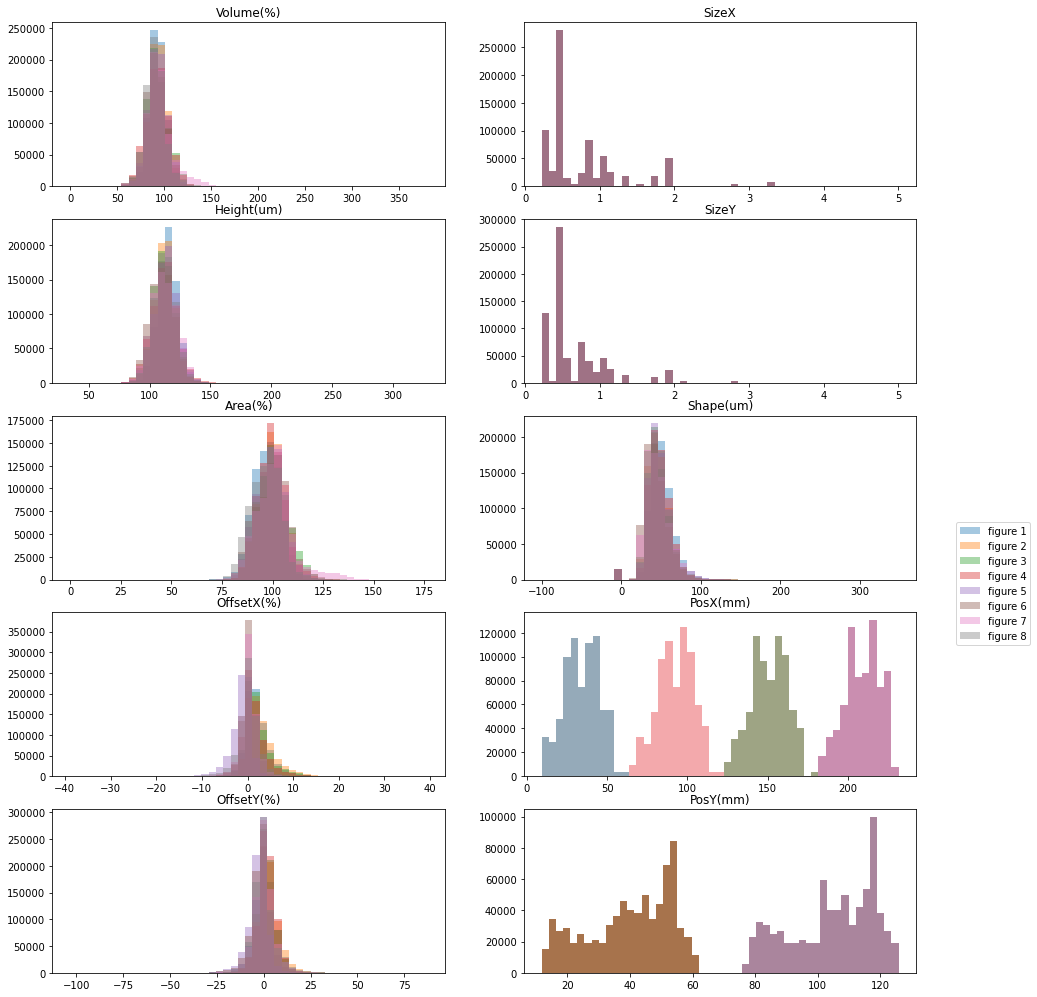

In [27]:
fig, ax = plt.subplots(5,2,figsize=(15,15))
for i,col_name in enumerate(['Volume(%)', 'Height(um)', 'Area(%)', 'OffsetX(%)', 'OffsetY(%)',
       'SizeX', 'SizeY', 'Shape(um)', 'PosX(mm)', 'PosY(mm)']):
#     InputSPI2=InputSPI.loc[InputSPI.Result=="GOOD"]
    bins=np.arange(min(InputSPI[col_name]),max(InputSPI[col_name]),(max(InputSPI[col_name])-min(InputSPI[col_name]))/50)
    for figureid in range(1,9):
        ax[i%5,i//5].hist(InputSPI.loc[InputSPI.FigureID==figureid, col_name],bins=bins,alpha=0.4, label="figure {}".format(figureid))
        ax[i%5,i//5].set_title(col_name)

plt.legend(loc=(1.1,2))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.98, wspace=0.2, hspace=0.2)

we can see that **figure number 7** had in general more Volume and Area than other figures. So let's explore their spatial distribution

In [28]:
look_at = InputSPI.groupby('PadID')['Volume(%)', 'Area(%)', 'PosX(mm)', 'PosY(mm)', 'FigureID'].mean()

/tmp/ipykernel_14231/3210020319.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  look_at = InputSPI.groupby('PadID')['Volume(%)', 'Area(%)', 'PosX(mm)', 'PosY(mm)', 'FigureID'].mean()


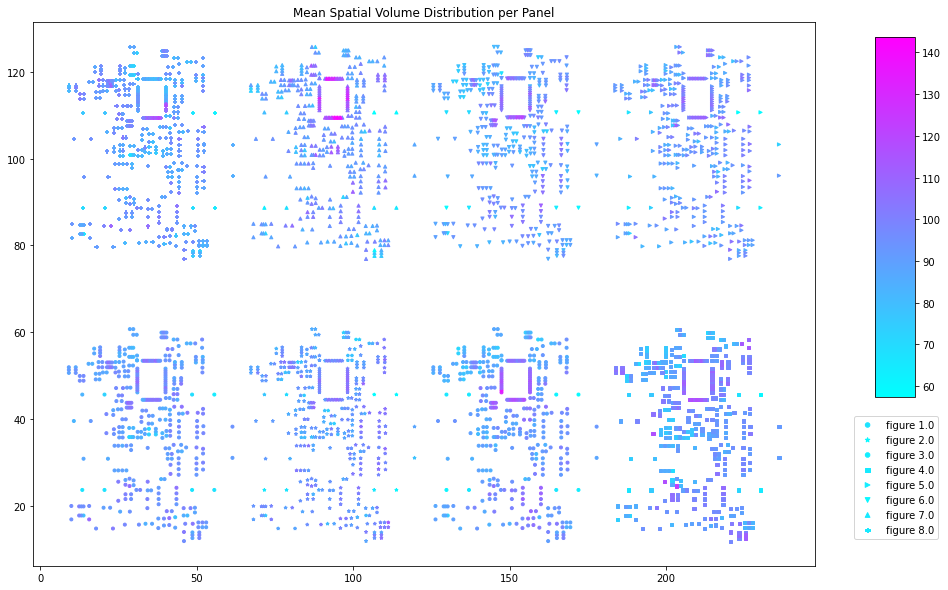

In [29]:
markers = ['.','*','8','s','>','v','^','P','x','d']
global_norm = matplotlib.colors.Normalize(vmin=look_at["Volume(%)"].min(), vmax=look_at["Volume(%)"].max())

for i,fig_id in enumerate(look_at.FigureID.unique()):
    data = look_at.loc[look_at['FigureID']==fig_id]
    if i==0:
        plt.scatter(x=data["PosX(mm)"], y=data["PosY(mm)"], c=data["Volume(%)"], marker=markers[i],label="figure {}".format(fig_id), norm=global_norm, cmap=matplotlib.cm.cool)
    else:
        plt.scatter(x=data["PosX(mm)"], y=data["PosY(mm)"], c=data["Volume(%)"], marker=markers[i],label="figure {}".format(fig_id), s=10, norm=global_norm, cmap=matplotlib.cm.cool)

plt.legend(loc=(1.05,0.05), markerscale=1.5)
plt.title("Mean Spatial Volume Distribution per Panel")
cax = plt.axes([0.96, 0.36, 0.04, 0.5])
plt.colorbar(cax=cax)


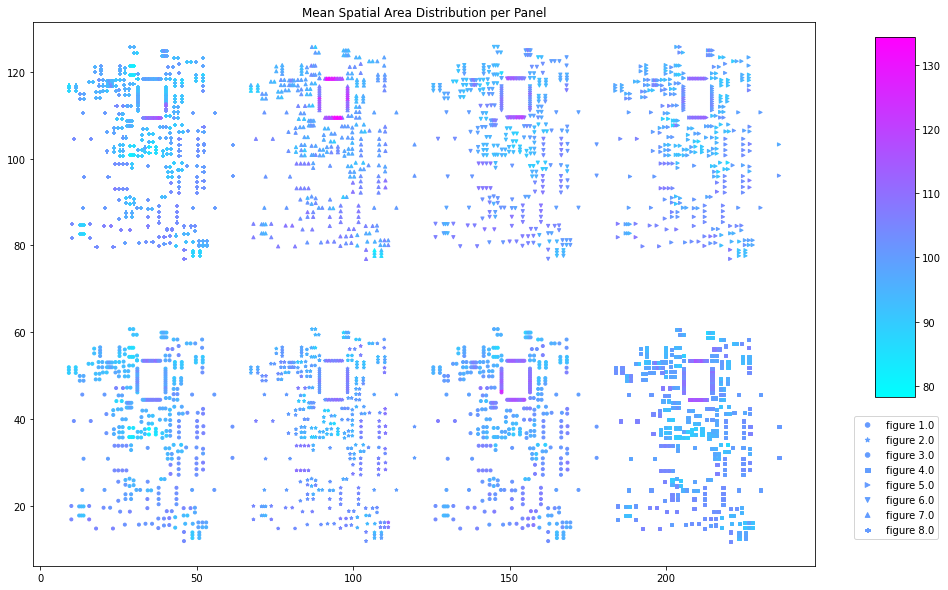

In [30]:
markers = ['.','*','8','s','>','v','^','P','x','d']
global_norm = matplotlib.colors.Normalize(vmin=look_at["Area(%)"].min(), vmax=look_at["Area(%)"].max())

for i,fig_id in enumerate(look_at.FigureID.unique()):
    data = look_at.loc[look_at['FigureID']==fig_id]
    if i==0:
        plt.scatter(x=data["PosX(mm)"], y=data["PosY(mm)"], c=data["Area(%)"], marker=markers[i],label="figure {}".format(fig_id), norm=global_norm, cmap=matplotlib.cm.cool)
    else:
        plt.scatter(x=data["PosX(mm)"], y=data["PosY(mm)"], c=data["Area(%)"], marker=markers[i],label="figure {}".format(fig_id), s=10, norm=global_norm, cmap=matplotlib.cm.cool)

plt.legend(loc=(1.05,0.05), markerscale=1.5)
plt.title("Mean Spatial Area Distribution per Panel")
cax = plt.axes([0.96, 0.36, 0.04, 0.5])
plt.colorbar(cax=cax)

The volume and Area excess seems to be located in a quad component (microprocessor?)


#Merge the SPI and AOI datasets
In order to merge both datasets the columns used as reference should have the same dtype. Let's check this

In [57]:
Merging_columns = ["PanelID","FigureID","ComponentID","PinNumber"]
print("SPI")
print(InputSPI[Merging_columns].dtypes)
print("AOI")
print(InputAOI[Merging_columns].dtypes)

SPI
PanelID         object
FigureID       float64
ComponentID     object
PinNumber       object
dtype: object
AOI
PanelID         object
FigureID         int64
ComponentID     object
PinNumber      float64
dtype: object


In [74]:
InputAOI["PinNumber"] = InputAOI["PinNumber"].astype(str).str.replace('.0','')

InputSPI["FigureID"] = InputSPI["FigureID"].astype(np.int64)
InputAOI["PinNumber"].dtype

/tmp/ipykernel_14231/1927179951.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  InputAOI["PinNumber"] = InputAOI["PinNumber"].astype(str).str.replace('.0','')


dtype('O')

In [86]:
Merge_outer=InputSPI.merge(InputAOI,how="outer",on=Merging_columns, sort=False, indicator=True)

In [90]:
Merge_outer

,PanelID,FigureID,ComponentID,PinNumber,PadID,PadType,Volume(%),Height(um),Area(%),OffsetX(%),...,PosX(mm),PosY(mm),Result,DateTime,MachineID,AOILabel,OperatorLabel,RepairLabel,_merge,Task_1
0,26319044800520102844,1,BC1,1,1.0,0.0,67.476,100.475,100.736,0.098,...,55.6,23.6,GOOD,2019-09-20 11:16:02,NaN,GOOD,NaN,NaN,left_only,False
1,26319044800520102844,1,BC1,2,2.0,0.0,64.805,100.431,96.791,0.830,...,48.5,23.6,GOOD,2019-09-20 11:16:02,B,UnSoldered,Good,NaN,both,True
2,26319044800520102844,1,BC2,1,3.0,0.0,63.165,97.871,96.808,-0.036,...,13.4,23.6,GOOD,2019-09-20 11:16:02,NaN,GOOD,NaN,NaN,left_only,False
3,26319044800520102844,1,BC2,2,4.0,0.0,66.680,100.762,99.264,0.146,...,20.5,23.6,GOOD,2019-09-20 11:16:02,NaN,GOOD,NaN,NaN,left_only,False
4,26319044800520102844,1,BC3,1,5.0,0.0,62.869,94.773,99.505,-0.262,...,55.6,45.6,GOOD,2019-09-20 11:16:02,NaN,GOOD,NaN,NaN,left_only,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5988451,27219026400520102844,3,R2,nan,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaT,A,Missing,Good,NaN,right_only,True
5988452,27219026400520102844,4,RA3,nan,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaT,A,Coplanarity,Good,NaN,right_only,True
5988453,27219026400520102844,4,RA3,nan,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaT,A,Size,Good,NaN,right_only,True
5988454,27219026400520102844,2,R2,nan,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaT,A,Missing,Good,NaN,right_only,True


In [87]:
Merge_outer["AOILabel"].unique()

array([nan, 'UnSoldered', 'LeanSoldering', 'Translated', 'Soldered',
       'Misaligned', 'Coplanarity', 'Jumper', 'Broken', 'Size', 'Missing',
       'Polarity'], dtype=object)

In [88]:
Merge_outer["Task_1"] = Merge_outer["AOILabel"].notna()
Merge_outer["AOILabel"].fillna('GOOD', inplace=True)
Merge_outer["AOILabel"].unique()

array(['GOOD', 'UnSoldered', 'LeanSoldering', 'Translated', 'Soldered',
       'Misaligned', 'Coplanarity', 'Jumper', 'Broken', 'Size', 'Missing',
       'Polarity'], dtype=object)

In [92]:
Merge_outer[Merge_outer["_merge"]=="right_only"]

,PanelID,FigureID,ComponentID,PinNumber,PadID,PadType,Volume(%),Height(um),Area(%),OffsetX(%),...,PosX(mm),PosY(mm),Result,DateTime,MachineID,AOILabel,OperatorLabel,RepairLabel,_merge,Task_1
5979271,26319044800520102844,2,C31,nan,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaT,A,Coplanarity,Good,NaN,right_only,True
5979272,26319045100520102844,4,C8,nan,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaT,A,Size,Good,NaN,right_only,True
5979273,26319045100520102844,7,R21,nan,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaT,A,Coplanarity,Good,NaN,right_only,True
5979274,26319045100520102844,7,D8,nan,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaT,A,Coplanarity,Good,NaN,right_only,True
5979275,26319045100520102844,7,L2,nan,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaT,A,Coplanarity,Good,NaN,right_only,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5988451,27219026400520102844,3,R2,nan,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaT,A,Missing,Good,NaN,right_only,True
5988452,27219026400520102844,4,RA3,nan,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaT,A,Coplanarity,Good,NaN,right_only,True
5988453,27219026400520102844,4,RA3,nan,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaT,A,Size,Good,NaN,right_only,True
5988454,27219026400520102844,2,R2,nan,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaT,A,Missing,Good,NaN,right_only,True
